# CP extracts coordinates from frames
In this experiment we test hypothesis that CP-aware model can extract coordinates of objects from frames using only "self-predictability" objective. No reconstruction objective is used.

## Setting

- **Input:** series of frames with one moving ball. The initial position of the ball and the direction of motion is chosen randomly, then 10-frames "movie" is generated. Magnitude of velocity is fixed.
- **Architecture:** convolutional encoder with 3 convolutional layers (relu + maxpool), then dense network is used to generate representation $h_t$ from frame $x_t$ (so $h_t$ depends only on $x_t$). The representation state is two-dimensional, $h_t\in \mathbb R^2$. Then Generator network is used to predict $h_{t+1}$ knowing previous $h_t$'s. This nework is GRU, so it knows full history. Conscious is trivial in this case, just choses full representation all the time (as the representation space is low-dimensional).
- **Objectives:** to ensure we are predicting something useful (i.e. not constant), we optimize $R^2$-like prediction loss, i.e. minimizing $\frac{RSS}{TSS}$, where $RSS$ is sum of squares of the residuals of generator network (all over timesteps and samples in a batch) and $TSS$ is total variance of components of $h_t$. To ensure that components of $h_t$ does not catch only one feature, we add correlation loss: minimize correlation betwen components of $h_t$.
- **Evaluation:** To test the hypothesis, we are using linear regression to reconstruct coordinates of the ball from $h_t$.

## Results
Hypothesis confirmed. CP-aware model that uses self-predictability objective only can succesfully reconstruct salient features of an image, i.e. coordinates of the ball.

## Code
### Input data generation

In [1]:
import numpy as np

In [2]:
def get_trajectories(num_samples, timesteps, vnorm=0.03, x0=None, phi0=None):
    """
    Returns data that is needed to train the model
    num_samples is number of samples
    timesteps is number of timesteps to generate
    vnorm is a velocity norm
    x0 is a start position
    phi0 is an angle
    
    returns 
        trajectories: shape == (num_samples, timesteps, 2)
    """
    x0 = (np.random.uniform(0, 1, size=(num_samples, 2)) 
          if x0 is None else x0)
    phi0 = (np.random.uniform(0, 2 * np.pi, size=(num_samples)) 
            if phi0 is None else phi0)
    v = np.stack([np.cos(phi0), np.sin(phi0)], axis=1) * vnorm
    t = np.arange(timesteps)
        
    trajectories = x0[:, np.newaxis, :] + np.einsum('t,sc->stc', t, v)
    # motion with constant speed

    return trajectories

In [3]:
def traj_to_frames(traj, xmin=-0.5, xmax=1.5, ymin=-0.5, ymax=1.5, 
                   pixels=64, r=0.2):
    """
    Converts trajectories generated by get_trajectories into frames
    
    Inputs:
    - traj: trajectory, (num_samples, timesteps, 2)-tensor, 
            typically output of get_trajectories)
    - xmin, xmax, ymin, ymax: bounding box (should contain position of 
        particle at all moments)
    - pixels: size of image
    - r: size of a ball
    
    Outputs:
    - frames: (num_samples, timesteps, pixels, pixels, 1)-tensor
    """
    X, Y = np.meshgrid(np.linspace(xmin, xmax, pixels),
                       np.linspace(ymin, ymax, pixels))
    
    x_traj = traj[:, :, 0][:, :, np.newaxis, np.newaxis]
    y_traj = traj[:, :, 1][:, :, np.newaxis, np.newaxis]
    
    assert ((xmax > x_traj).all() and (ymax > y_traj).all() 
            and (x_traj > xmin).all() and y_traj > ymin).all(), \
        "Particle  outside bounds"
    
    frames = np.exp(-(((X-x_traj)**2+(Y-y_traj)**2)/r**2)**4)
    
    frames[frames > 1] = 1
    frames[frames < 0.1] = 0
    
    return frames[:, :, :, :, np.newaxis]

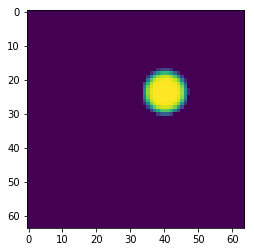

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from IPython.display import HTML

timesteps = 10
frames_for_animation = traj_to_frames(get_trajectories(1, timesteps))

def draw(n, ax):
    ax.clear()
    ax.imshow(frames_for_animation[0, n, :, :, 0])
    return ax

def ani_frame():
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    draw(0, ax)
    
    ani = animation.FuncAnimation(fig, lambda n: draw(n, ax), timesteps,
                                  interval=200)
    return ani

ani = ani_frame()
HTML(ani.to_html5_video())

## Model definition

In [5]:
from keras.layers import (Conv2D, TimeDistributed, Input, MaxPooling2D, 
                          Flatten, Dense, GRU, Lambda, Subtract, Multiply)
from keras.models import Sequential, Model
from keras import backend as K

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
# FROM: https://github.com/mkturkcan/TheConsciousnessPrior/blob/master/src/keras_train_baseline.py
# iD = Input(shape=X.shape[1:])
# xD = TimeDistributed(Conv2D(16, (3, 3), padding='same', activation = 'relu', 
#                             data_format='channels_last'), input_shape=X.shape)(iD)
# xD = TimeDistributed(MaxPooling2D())(xD)
# xD = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation = 'relu'))(xD)
# xD = TimeDistributed(MaxPooling2D())(xD)
# xD = TimeDistributed(Flatten())(xD)

In [7]:
timesteps = 10
framesize = 64
filters = 16
representation_dim = 2
generator_dim = 8

input_shape = (timesteps, framesize, framesize, 1)

inputs = Input(shape=input_shape, name="Input")
# Representation is convolutional network

representation = Sequential(name="representation")
representation.add(TimeDistributed(
    Conv2D(filters, (3, 3), strides=(2, 2), 
           padding='same', activation='relu',
           data_format='channels_last'), input_shape=input_shape))
representation.add(TimeDistributed(MaxPooling2D()))
representation.add(TimeDistributed(
    Conv2D(filters * 2, (3, 3), strides=(2, 2), 
           padding='same', activation='relu',
           data_format='channels_last', 
           input_shape=input_shape)))
representation.add(TimeDistributed(MaxPooling2D()))
representation.add(TimeDistributed(
    Conv2D(filters * 4, (3, 3), strides=(2, 2), 
           padding='same', activation='relu',
           data_format='channels_last', 
           input_shape=input_shape)))
representation.add(TimeDistributed(MaxPooling2D()))
representation.add(TimeDistributed(Flatten()))
representation.add(TimeDistributed(Dense(representation_dim)))

h = representation(inputs)


# Generator is GRU

generator_rnn = GRU(generator_dim, return_sequences=True)
generator_dense = Dense(representation_dim)

h_hat = generator_dense(generator_rnn(h))
# h_hat is prediction of future h

h_hat_shifted = Lambda(lambda x: x[:,:-1,:], 
                       output_shape=(timesteps - 1, 
                                     representation_dim))(h_hat)
h_shifted = Lambda(lambda x: x[:, 1:, :],
                  output_shape=(timesteps - 1, representation_dim))(h)
# we are stripping out the last element of h_hat and first element of h
# to align them properly

def rss(y_true, y_pred):
    """
    Calculate RSS over all timesteps and all samples in a batch
    """
    return K.mean(K.square(y_true - y_pred), axis=(0, 1))

def tss(y):
    """
    Calculate TSS over all timesteps and all samples in a batch
    """
    return rss(y, K.mean(y, axis=(0, 1), keepdims=True))

def mean_rsquared(y_true, y_pred):
    """
    Calculates RSS / TSS, averaged over all components
    """
    # add K.epsilon() to denomenator to avoid division by zero
    return K.mean(rss(y_true, y_pred) / (tss(y_true) + K.epsilon()), axis=-1)

def r2_between_components(inp):
    """
    Calculates r^2 (sqare of Pearson's correlation) between first two
        components of a tensor, used to make sure that learned components
        are independent of each other
    """
    x, y = inp[:, :, 0], inp[:, :, 1]
    mx = K.mean(x)
    my = K.mean(y)
    D_x = K.mean(K.square(x - mx))
    D_y = K.mean(K.square(y - my))
    
    return K.square(K.mean((x - mx) * (y - my))) / D_x / D_y

h_loss = Lambda(lambda x: mean_rsquared(x[0], x[1]),
                output_shape=(1,), 
                name="prediction_error")([h_shifted, h_hat_shifted])

corr_loss = Lambda(lambda x: r2_between_components(x),
                output_shape=(1,), name="corr")(h_shifted)

def id_loss(y_true, y_pred):
    """
    Dummy identity loss, just returns y_pred 
        (assuming output of a model is alread a loss)
    """
    return y_pred

model = Model([inputs], [h_loss, corr_loss])
model.compile(optimizer='adam', loss=[id_loss, id_loss])

model_repr = Model([inputs], [h, h_hat])

In [8]:
num_samples = 1000
timesteps = 10
trajectories = get_trajectories(num_samples=num_samples, 
                                   timesteps=timesteps)

In [9]:
frames = traj_to_frames(trajectories)

In [10]:
epochs = 50
batch_size=128
model.compile(optimizer='adam', loss=id_loss)

# use fake expected data as our model doesn't need it
model.fit([frames], [np.zeros(shape=(num_samples, 1)), 
                     np.zeros(shape=(num_samples, 1))],
                              epochs=epochs, batch_size=batch_size)

Epoch 1/50
1000/1000 [==============================] - 6s 6ms/step - loss: 1.4137 - prediction_error_loss: 1.2457 - corr_loss: 0.1680
Epoch 2/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.8988 - prediction_error_loss: 0.8692 - corr_loss: 0.0296
Epoch 3/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7873 - prediction_error_loss: 0.7260 - corr_loss: 0.0613
Epoch 4/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7333 - prediction_error_loss: 0.6777 - corr_loss: 0.0556
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6890 - prediction_error_loss: 0.6532 - corr_loss: 0.0359
Epoch 6/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6343 - prediction_error_loss: 0.6022 - corr_loss: 0.0321
Epoch 7/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5950 - prediction_error_loss: 0.5608 - corr_loss: 0.0342
Epoch 8/50
1000/1000 [==============================] -

### Model evaluation
#### Evaluation on data used in training 

In [11]:
import pandas as pd
import warnings
from pandas.tools.plotting import scatter_matrix
warnings.filterwarnings('ignore')

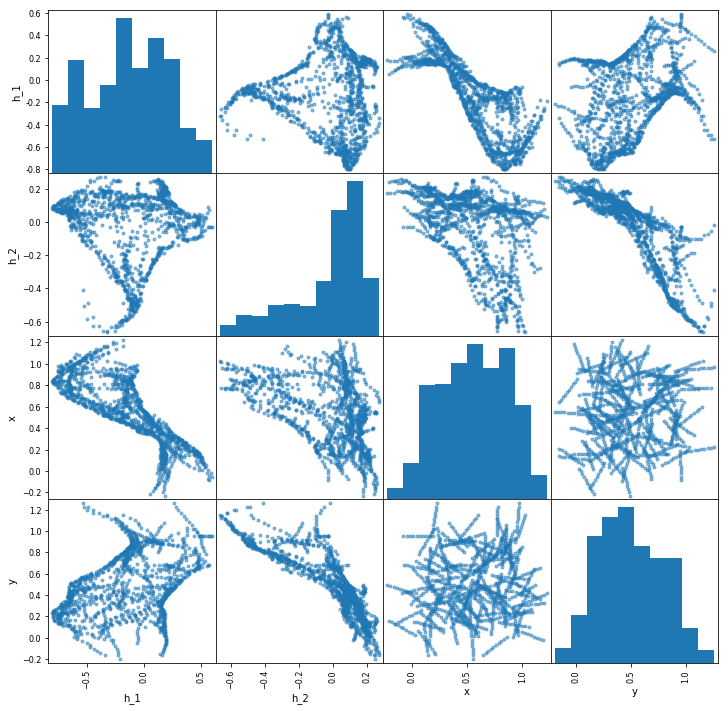

In [12]:
sample = 0
batch = slice(sample, sample + batch_size)
df = pd.DataFrame(
    np.concatenate([np.concatenate(model_repr.predict(frames[batch])[0]
                                  ).reshape(-1, 2),
                np.concatenate(trajectories[batch])], axis=1),
    columns=['h_1', 'h_2', 'x', 'y'])
plt.figure(figsize=(12, 12))
scatter_matrix(df[['h_1', 'h_2', 'x', 'y']], ax=plt.gca());

#### Generate data for evaluation
We generate here images for ball position on grid steps × steps.

In [13]:
steps = 50
x, y = np.meshgrid(np.linspace(0, 1, steps),
                   np.linspace(0, 1, steps))
pseudo_traj = np.concatenate([x[:, :, np.newaxis], 
                    y[:, :, np.newaxis]], axis=-1).reshape(-1, 10, 2)
pseudo_frames = traj_to_frames(pseudo_traj)
rep = model_repr.predict(pseudo_frames)[0].reshape(steps, steps, 2)

Visualise representation's components as functions of true $x, y$. 

In [14]:
from plotly.offline import iplot, init_notebook_mode
from plotly.graph_objs import Surface
init_notebook_mode()
iplot([Surface(x=x, y=y, z=rep[:, :, 0]),
       Surface(x=x, y=y, z=rep[:, :, 1])])

We see from the image above, that representation is near-linear function of $x, y$. Let us reconstruct $x$ and $y$ from the components of $h$ using linear regression.

In [15]:
df = pd.DataFrame(
    np.concatenate([rep.reshape(-1, 2), 
                    pseudo_traj.reshape(-1, 2)], axis=1),
    columns=['h_1', 'h_2', 'x', 'y'])

In [16]:
from statsmodels.formula.api import ols

In [17]:
x_of_h_model = ols('x ~ h_1 + h_2', data=df).fit()
y_of_h_model = ols('y ~ h_1 + h_2', data=df).fit()

In [18]:
x_of_h_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      x   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 1.575e+04
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        12:26:25   Log-Likelihood:                 2772.9
No. Observations:                2500   AIC:                            -5540.
Df Residuals:                    2497   BIC:                            -5522.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4266      0.002    258.415      0.000       0.423       0.430
h_1           -0.7036      0.004   -161.213      0.000      -0.712      -0.695
h_2           -0.6692      0.008    -84.790      0.000      -0.685      -0.654
==============================================================================
Omnibus:                        4.769   Durbin-Watson:                   0.326
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.763
Skew:                           0.085   Prob(JB):                       0.0924
Kurtosis:                       3.129   Cond. No.                         4.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
y_of_h_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     5820.
Date:                Sun, 04 Feb 2018   Prob (F-statistic):               0.00
Time:                        12:26:25   Log-Likelihood:                 1675.8
No. Observations:                2500   AIC:                            -3346.
Df Residuals:                    2497   BIC:                            -3328.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5092      0.003    198.880      0.000       0.504       0.514
h_1            0.2971      0.007     43.893      0.000       0.284       0.310
h_2           -1.1680      0.012    -95.424      0.000      -1.192      -1.144
==============================================================================
Omnibus:                       79.031   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.231
Skew:                          -0.387   Prob(JB):                     2.80e-17
Kurtosis:                       2.635   Cond. No.                         4.97
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results of these regressions are rather good ($R^2$ is rather large in both cases). It means that even simple linear model can reconstruct $x$ and $y$ from $h$. In other words, $h$ is just a non-trivial linear combination of $x$ and $y$.

Let us visualize the relations between $x$, $y$ and their reconstructions.

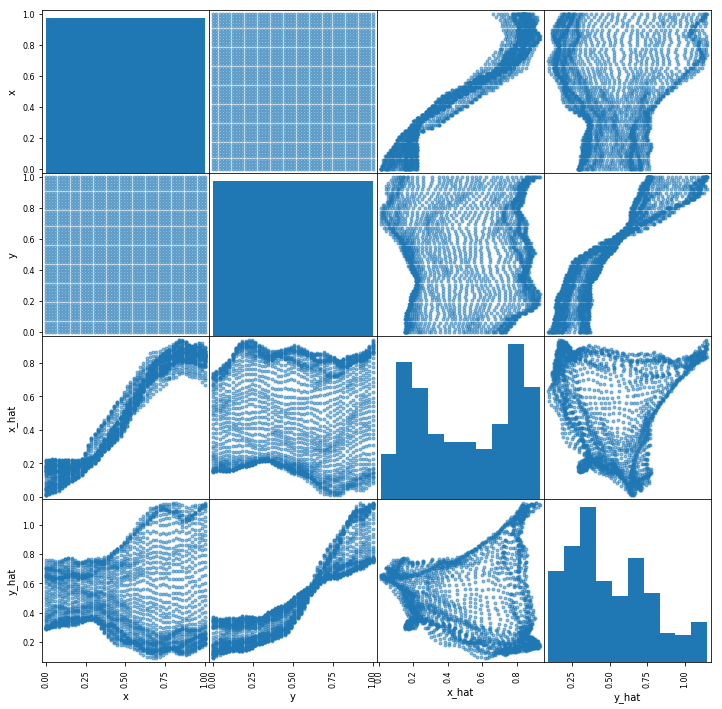

In [20]:
plt.figure(figsize=(12, 12))
scatter_matrix(df[['x', 'y']].assign(x_hat=x_of_h_model.predict(),
                                     y_hat=y_of_h_model.predict()), 
                                     ax=plt.gca());

From this picture we see that the results are rather good, however the actual dependency is non-linear (which is quite natural to expect).

## Conclusion
We demonstrated that it is possible to recover $x$ and $y$ out of the representation that knew nothing about $x$ and $y$ and only tried to extract "something predictable and independent" from the sequence of frames.